## Step 1: Data Loading and Preparation

In this step, we load the customer transaction data and prepare it for further analysis. Data preparation is a crucial phase in any data science workflow, ensuring the dataset is clean, well-structured, and ready for feature engineering.

### Objectives:
- Load the dataset into a pandas DataFrame.
- Inspect the first few records to understand the structure.
- Check for and handle missing values.
- Convert `TransactionDate` column to proper datetime format.
- Identify potential outliers in key numeric columns.

This foundational step ensures the reliability of insights derived in later stages, especially during RFM analysis and clustering.


In [8]:
# Import required libraries
import pandas as pd

# Load the customer transaction dataset
df = pd.read_csv("customer_transactions_mock_data.csv")

# Display the first few rows of the dataset
print(" Preview of the dataset:")
display(df.head())

# Check for missing values
print("\n Missing values in each column:")
print(df.isnull().sum())

# Convert TransactionDate to datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Summary statistics to check for outliers and data distribution
print("\n Summary statistics of numeric columns:")
print(df.describe())

# Check for unique counts of customers, transactions, and products
print("\n Unique value counts:")
print(f"Unique Customers     : {df['CustomerID'].nunique()}")
print(f"Unique Transactions  : {df['TransactionID'].nunique()}")
print(f"Unique Products      : {df['ProductID'].nunique()}")


 Preview of the dataset:


,TransactionID,CustomerID,TransactionDate,ProductID,Quantity,UnitPrice,TotalPrice
0,TRX50000_0,CUST1302,2022-01-12,Prod_107,3,53.74,161.22
1,TRX50000_1,CUST1302,2022-01-12,Prod_104,2,43.15,86.30
2,TRX50000_2,CUST1302,2022-01-12,Prod_107,1,59.80,59.80
3,TRX50001_0,CUST1267,2023-10-17,Prod_108,1,214.31,214.31
4,TRX50001_1,CUST1267,2023-10-17,Prod_109,3,312.02,936.06



 Missing values in each column:
TransactionID      0
CustomerID         0
TransactionDate    0
ProductID          0
Quantity           0
UnitPrice          0
TotalPrice         0
dtype: int64

 Summary statistics of numeric columns:
                     TransactionDate      Quantity     UnitPrice    TotalPrice
count                          15143  15143.000000  15143.000000  15143.000000
mean   2022-12-28 14:33:25.996169984      1.998349    103.732894    207.328918
min              2022-01-01 00:00:00      1.000000      1.220000      1.540000
25%              2022-06-27 12:00:00      1.000000     34.010000     58.740000
50%              2022-12-28 00:00:00      2.000000     76.970000    137.970000
75%              2023-07-01 00:00:00      3.000000    154.180000    285.340000
max              2023-12-30 00:00:00      3.000000    393.870000   1181.610000
std                              NaN      0.818851     85.986186    203.743701

 Unique value counts:
Unique Customers     : 500
Uniqu

## Step 2: RFM Feature Engineering

In this step, we compute the three core behavioral metrics—Recency, Frequency, and Monetary value—for each customer. These metrics serve as the foundation for segmentation.

### Objectives:
1. Define a snapshot date (typically one day after the last transaction) to measure recency.
2. Calculate **Recency** as the number of days since each customer’s most recent purchase.
3. Calculate **Frequency** as the total number of transactions per customer.
4. Calculate **Monetary** as the total revenue generated by each customer.
5. Aggregate these metrics into a single `rfm` DataFrame for further analysis.

These RFM features capture how recently and often customers buy, and how much they spend—key dimensions for understanding customer value and loyalty.


In [10]:
# Step 2: RFM Feature Engineering
import pandas as pd
from datetime import timedelta

# Assume df is already loaded and TransactionDate is datetime
# Define snapshot date as one day after the latest transaction
snapshot_date = df['TransactionDate'].max() + timedelta(days=1)

# Group by CustomerID and compute RFM metrics
rfm = df.groupby('CustomerID').agg(
    Recency = ('TransactionDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('TransactionID', 'nunique'),
    Monetary  = ('TotalPrice', 'sum')
).reset_index()

# Display the first few rows of the RFM table
print(" Preview of RFM metrics:")
display(rfm.head())

# Summary statistics to understand distribution
print("\n RFM summary statistics:")
print(rfm[['Recency','Frequency','Monetary']].describe())


 Preview of RFM metrics:


,CustomerID,Recency,Frequency,Monetary
0,CUST1000,9,41,6855.79
1,CUST1001,49,10,2856.43
2,CUST1002,7,25,2175.73
3,CUST1003,22,33,1085.57
4,CUST1004,134,27,6887.81



 RFM summary statistics:
          Recency   Frequency    Monetary
count  500.000000  500.000000    500.0000
mean    71.310000   30.286000   6279.1636
std     65.035075   10.224543   4430.0027
min      1.000000    4.000000    377.0000
25%     22.000000   23.000000   2579.4425
50%     54.000000   30.000000   5292.9750
75%    105.250000   37.000000   9319.3500
max    500.000000   57.000000  20453.5000


## Step 3: Exploratory Data Analysis (EDA) and Feature Scaling

Before clustering, it's essential to:
1. **Visualize** the distribution of RFM metrics to check for skewness and outliers.
2. Apply **log transformation** to normalize the skewed features (especially `Monetary` and `Frequency`).
3. **Scale** the data using StandardScaler or MinMaxScaler—this is crucial because clustering models (like K-Means) are distance-based and sensitive to feature magnitude.

### Key Goals:
- Ensure that Recency, Frequency, and Monetary features are on similar scales.
- Reduce the impact of outliers and skewness on clustering performance.


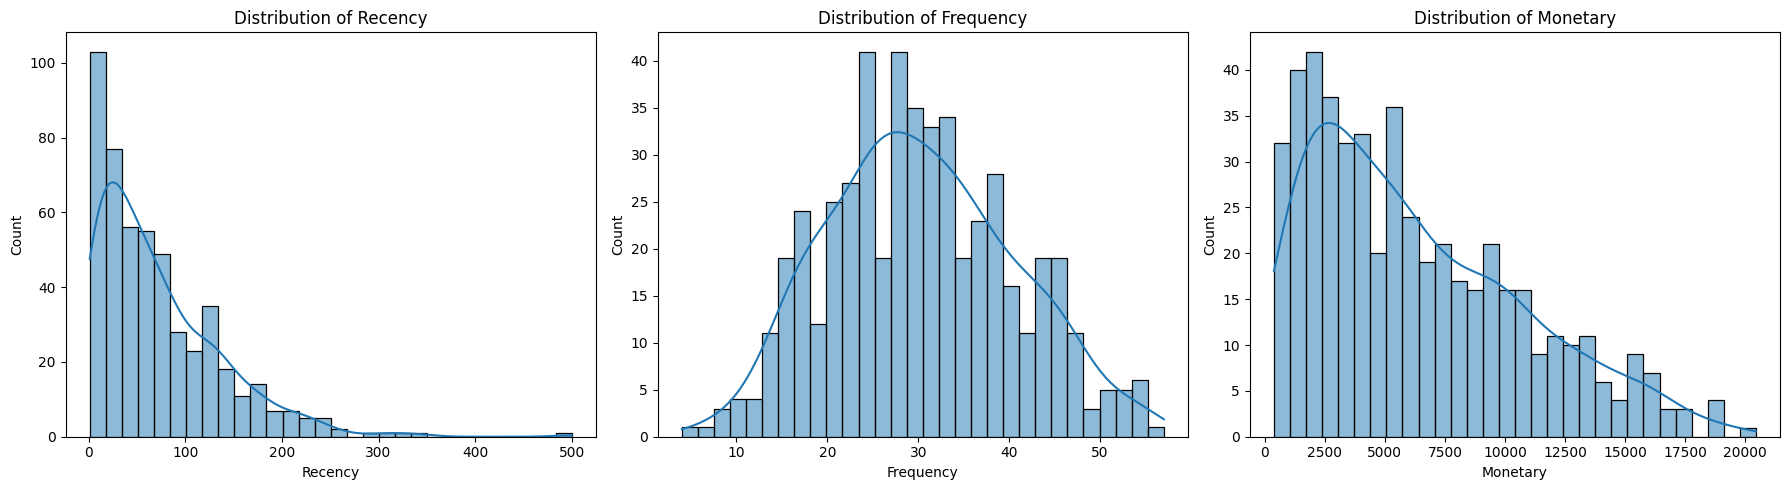

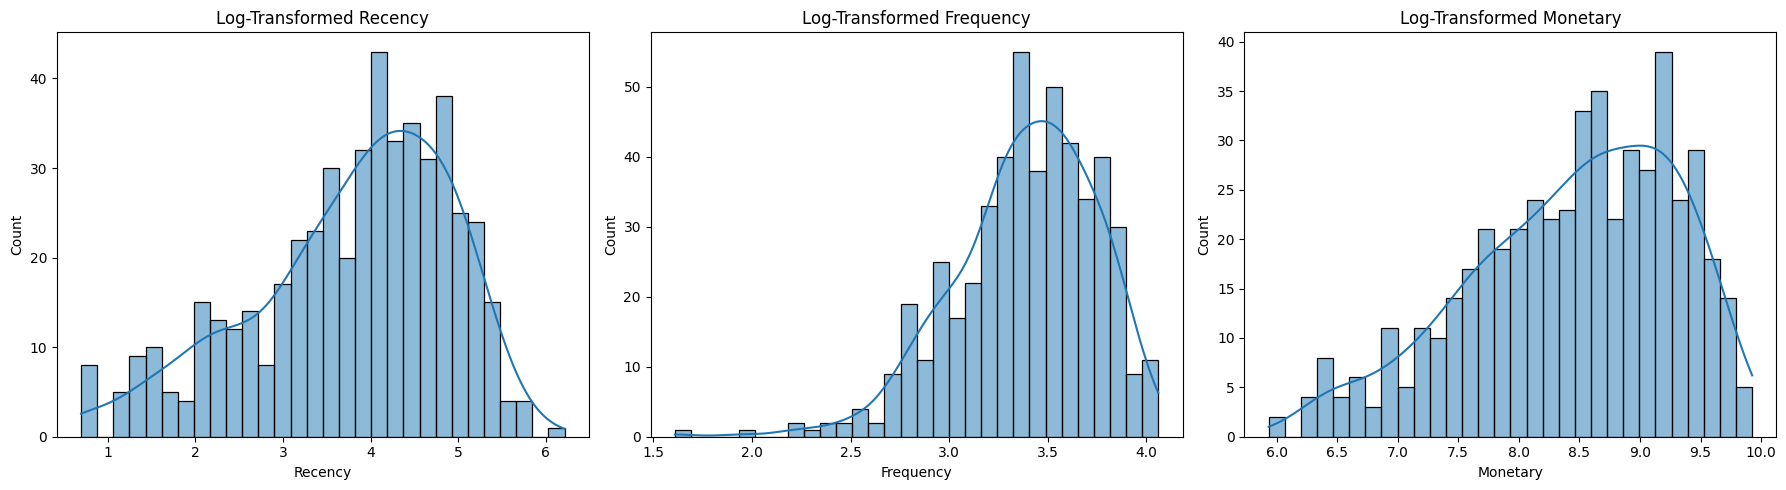

 Log-transformation and scaling complete. Ready for clustering.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

# Plot original distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.histplot(rfm[feature], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Log transformation to handle skewness
rfm_log = rfm.copy()
rfm_log[['Recency', 'Frequency', 'Monetary']] = rfm_log[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log1p(x))

# Plot transformed distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.histplot(rfm_log[feature], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Log-Transformed {feature}')
plt.tight_layout()
plt.show()

# Standard scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])

# Store scaled RFM in a DataFrame for clustering
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print(" Log-transformation and scaling complete. Ready for clustering.")


##  Step 4: Clustering

Now that our RFM data is transformed and scaled, it's time to segment the customers using a clustering algorithm.

We'll go with **K-Means Clustering**, one of the most widely used unsupervised learning methods for customer segmentation.

---

###  Objectives:
- Find the optimal number of clusters using:
  - **Elbow Method**
  - **Silhouette Score**
- Apply **KMeans** to the scaled RFM dataset.
- Attach the cluster labels to customer IDs.
- Visualize the cluster distribution.

---

###  Why K-Means?

- It’s fast and efficient for large datasets.
- It works well when the clusters are spherical (which is often the case after scaling).
- It's widely used in marketing for customer segmentation.

---

###  Determine Optimal Number of Clusters

We'll loop through values of `k` (2 to 10) and capture both:
- Inertia (sum of squared distances to cluster centers)
- Silhouette Score (measures how well clusters are separated)

We'll use these plots to decide the best `k`.

---

###  Visualization: Elbow & Silhouette Method

Let’s plot both graphs side by side.


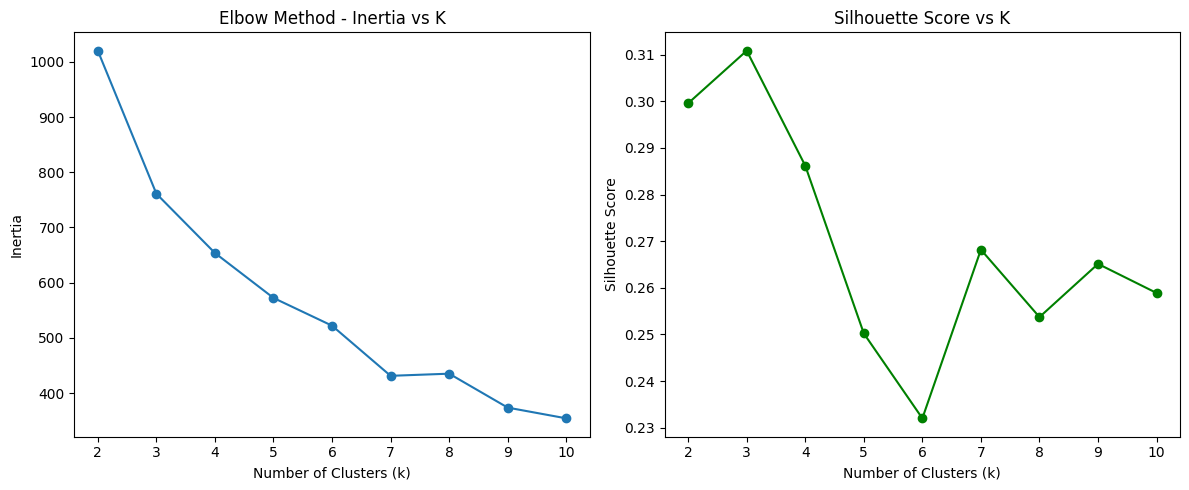

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow & Silhouette method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled_df, kmeans.labels_))

# Plotting
plt.figure(figsize=(12, 5))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method - Inertia vs K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


## step 5 Clustering: Applying K-Means with k=3

Based on our Elbow Method and Silhouette Score analysis, we chose **k = 3** as the optimal number of clusters. 

In this step, we will:
- Apply K-Means clustering with `k=3` on the scaled RFM data
- Assign cluster labels to each customer
- Visualize the clusters to understand how customers are grouped


In [14]:
from sklearn.cluster import KMeans

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(rfm_scaled)

# Assign cluster labels
rfm['Cluster'] = kmeans.labels_


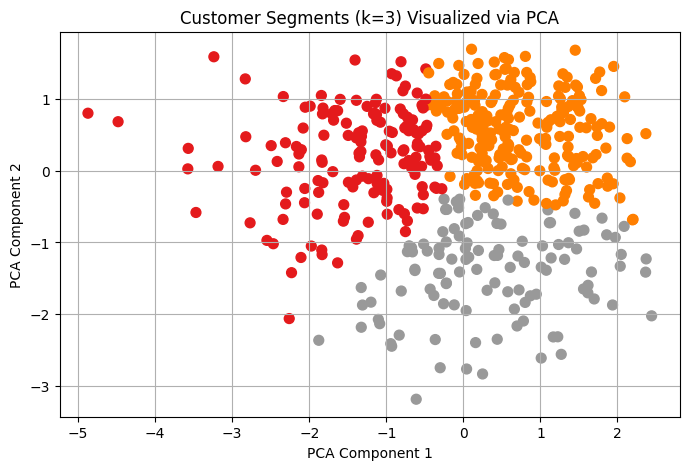

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=rfm['Cluster'], cmap='Set1', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segments (k=3) Visualized via PCA')
plt.grid(True)
plt.show()


### Interpretation of PCA Cluster Plot

- The plot shows **3 distinct customer segments** after clustering with K=3.
- **Cluster 0 (Orange)** is the largest group, indicating a common customer segment.
- **Cluster 1 (Grey)** and **Cluster 2 (Red)** are smaller but well-separated, suggesting distinct customer behaviors.
- Some minor overlap exists between clusters 1 and 2, which is typical in real-world data.
- Overall, the clusters demonstrate good separation, supporting that the chosen number of clusters is reasonable.


### step 6.Segment Profiling and Interpretation




In [17]:
# Calculate average RFM values per cluster and count of customers
segment_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

print(segment_profile)


   Cluster     Recency  Frequency     Monetary  Count
0        0  106.435065  20.746753  2903.189091    154
1        1   78.099138  36.357759  9011.476078    232
2        2   10.043860  30.815789  5279.195000    114


## Customer Segment Summary

- **Cluster 0 – At-Risk Low Spenders**  
  Customers who haven't purchased in a while and spend less. Need re-engagement.

- **Cluster 1 – Loyal High Spenders**  
  Frequent buyers who spend the most. Most valuable group.

- **Cluster 2 – New or Active Medium Spenders**  
  Recently active customers with average spending. Good potential to grow.


##  Final Report: Customer Segmentation Insights

###  Cluster Overview

| Cluster | Recency (avg) | Frequency (avg) | Monetary (avg) | Count |
|---------|---------------|-----------------|----------------|-------|
| 0       | 106.4         | 20.7            | 2903.18        | 154   |
| 1       | 78.1          | 36.4            | 9011.47        | 232   |
| 2       | 10.0          | 30.8            | 5279.19        | 114   |

---

###  Segment Descriptions & Strategies

- **Cluster 0 – At-Risk Low Spenders**
  -  Customers with high recency and low frequency/monetary.
  -  Strategy: Run win-back campaigns with special discounts or personalized offers to re-engage.

- **Cluster 1 – Loyal High Spenders**
  -  Most valuable customers; high frequency and highest spending.
  -  Strategy: Create VIP programs, early access to sales, and premium customer support.

- **Cluster 2 – Active Medium Spenders**
  -  Recently active, moderate spenders.
  -  Strategy: Use upselling tactics, product recommendations, and targeted follow-ups to increase CLV.

---

###  Key Takeaway:
Segmenting customers using RFM analysis has helped us uncover actionable groups for targeted marketing. Focusing on retaining loyal customers and re-engaging the at-risk ones can significantly boost business growth.

